In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
network = 'tarbase'

file_path_1 = f'./output/{network}_om.z_1000.tsv'
file_path_2 = f'./output/{network}_pm.z_1000.tsv'

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [7]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

mirna_lno_dict['MIRLET7E'][0]

'Bilateria'

In [8]:
df_wgd = df_1
df_ssd = df_2

In [9]:
print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  537


In [10]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

df_ssd = df_ssd[
    ~(
        df_ssd["miRNA_1"].apply(all_clades_in_pre2R) &
        df_ssd["miRNA_2"].apply(all_clades_in_pre2R)
    )
]

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  225


In [11]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

In [12]:
print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd))

Number of WGD pairs after removing miRNA pairs from SSD:  113
Number of SSD pairs after removing miRNA pairs from SSD:  220


In [17]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_bifan" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_vmotif'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_vmotif'] != 0)
    df = df[~mask_remove]

    return df

df_wgd = remove_sigma_err(df_wgd)
df_ssd = remove_sigma_err(df_ssd)

In [18]:
df_wgd_zscores = df_wgd['Z-score'].astype(float)
df_ssd_zscores = df_ssd['Z-score'].astype(float)

In [19]:
df_wgd_nbifan = df_wgd['n_vmotif'].astype(int)
df_ssd_nbifan = df_ssd['n_vmotif'].astype(int)

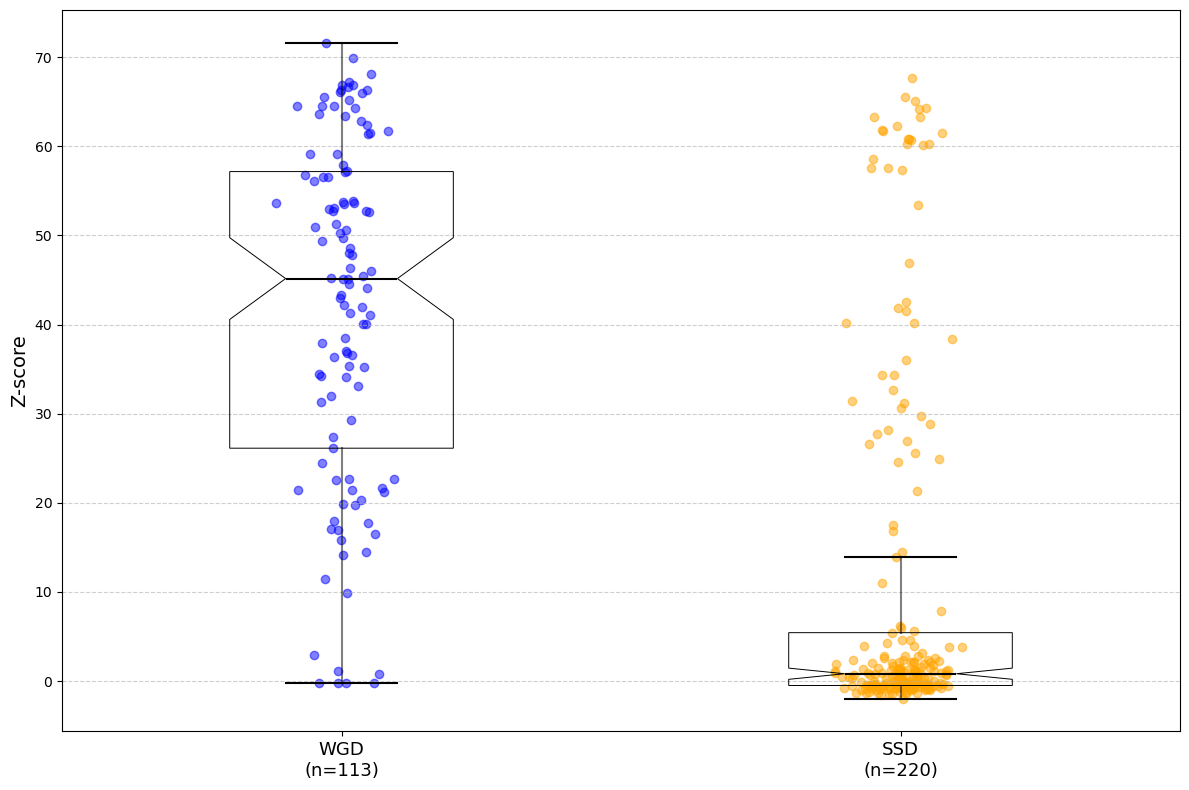

In [20]:
# Sample sizes
n_wgd = len(df_wgd_zscores)
n_ssd = len(df_ssd_zscores)

# Jittered x positions
x_wgd = np.random.normal(0, 0.04, size=n_wgd)
x_ssd = np.random.normal(1, 0.04, size=n_ssd)

plt.figure(figsize=(12, 8))

# Boxplot with transparent fill and notches
box = plt.boxplot(
    [df_wgd_zscores, df_ssd_zscores],
    positions=[0, 1],
    widths=0.4,
    notch=True,
    patch_artist=True,
    showfliers=False
)

# Make boxes transparent
for patch in box['boxes']:
	patch.set_facecolor('none')
	patch.set_edgecolor('black')
	patch.set_linewidth(0.7)

# Customize other boxplot parts
for element in ['medians', 'whiskers', 'caps']:
    for line in box[element]:
        line.set_color('black')
        line.set_linewidth(1.5)
        # width of the whiskers
        if element == 'whiskers':
            line.set_alpha(0.5)

# Jittered dots
plt.scatter(x_wgd, df_wgd_zscores, alpha=0.5, color='blue', label='WGD')
plt.scatter(x_ssd, df_ssd_zscores, alpha=0.5, color='orange', label='SSD')

# Labels
plt.ylabel('Z-score', fontsize=14)
plt.xticks([0, 1], [f'WGD\n(n={n_wgd})', f'SSD\n(n={n_ssd})'], fontsize=13)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [21]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_zscores, df_ssd_zscores)
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS statistic: 0.706234915526951, p-value: 1.855798309214639e-36


In [22]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['Z-score'].astype(float) > 1]
df_ssd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_vmotif,n_maj_true,Z-score,pValue (nm size=1000)
41,MIR1185-1,MIR1185-2,63,63,63,1.014,1.029468,63,0,60.211692,0.000000
51,MIR1185-1,MIR494,63,54,2,0.895,0.934866,2,221,1.181987,0.118605
62,MIR1185-2,MIR494,63,54,2,0.866,0.894452,2,212,1.267816,0.102432
65,MIR382,MIR323A,149,166,9,6.029,2.324255,9,144,1.278259,0.100579
66,MIR382,MIR369,149,41,4,1.496,1.181518,4,48,2.119308,0.017032
...,...,...,...,...,...,...,...,...,...,...,...
476,MIR941-2,MIR941-4,21,21,21,0.109,0.321121,21,0,65.056378,0.000000
477,MIR941-2,MIR941-5,21,21,21,0.132,0.364110,21,0,57.312371,0.000000
478,MIR941-3,MIR941-4,21,21,21,0.097,0.309178,21,0,67.608316,0.000000
479,MIR941-3,MIR941-5,21,21,21,0.114,0.330158,21,0,63.260709,0.000000


In [23]:
df_wgd_high_z = df_wgd[df_wgd['Z-score'].astype(float) > 3]
df_wgd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_vmotif,n_maj_true,Z-score,pValue (nm size=1000)
0,MIR101-1,MIR101-2,190,159,159,7.334,2.472740,159,0,61.335195,0.0
1,MIR103A1,MIR103A2,950,1075,950,192.885,11.318117,950,0,66.894077,0.0
2,MIR103A1,MIR107,950,959,927,174.186,11.057640,927,0,68.080892,0.0
3,MIR103A2,MIR107,1075,959,930,193.784,11.455625,930,0,64.266769,0.0
4,MIR106A,MIR106B,538,398,205,46.433,6.068403,205,0,26.129940,0.0
...,...,...,...,...,...,...,...,...,...,...,...
108,MIRLET7A2,MIRLET7E,926,355,262,68.171,7.077412,262,0,27.386989,0.0
109,MIRLET7C,MIRLET7E,328,355,247,26.765,4.886489,247,0,45.070192,0.0
110,MIRLET7D,MIRLET7G,614,620,215,79.724,7.923372,215,0,17.073034,0.0
111,MIRLET7D,MIRLET7I,614,478,202,62.692,7.012356,202,0,19.866077,0.0


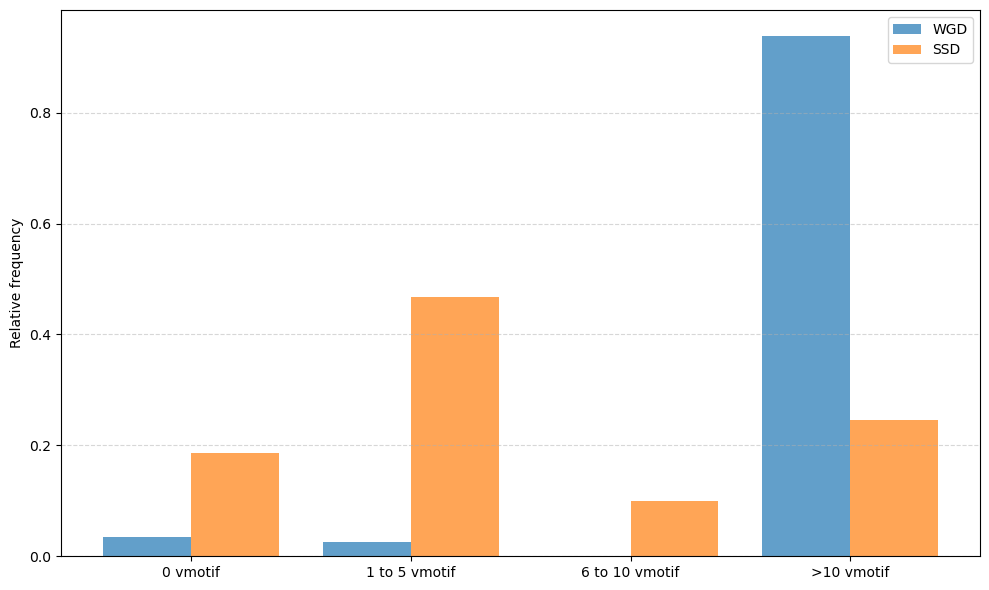

In [ ]:
def bin_bifans(count):
    if count == 0:
        return '0'
    else:
        return 'At least 1 vmotif'

# Bin the counts
wgd_binned = pd.Series(df_wgd_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(['0', 'At least 1 bifan'], fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(['0', 'At least 1 bifan'], fill_value=0)

# Plot
labels = ['0 bifan', 'At least 1 bifan']
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels)
plt.xlabel('')
plt.ylabel('Relative frequency')
plt.title('')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()